# cifar-10 cnn

## imports

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## devices

In [8]:
def get_available_pus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
get_available_pus()

['/cpu:0']

## data

In [9]:
def unpickle(file):
    with open(file, "rb") as f:
        data_map = pickle.load(f, encoding="bytes")
    return data_map

In [12]:
data = unpickle("../my_datasets/cifar-10-batches-py/data_batch_1")

In [13]:
#10000 images, 1024 pixels (and 3 color channels, 1024 * 3)
data[b"data"].shape

(10000, 3072)

In [14]:
type(data[b"data"])

numpy.ndarray

In [15]:
num_images = data[b"data"].shape[0]
num_pixels = int(data[b"data"].shape[1] / 3)
num_colors = 3
img_dim = [int(num_pixels ** .5)] * 2
print("images: {}\ndimensions: {}\npixels: {}\ncolors: {}".format(
    num_images, img_dim, num_pixels, num_colors
))

images: 10000
dimensions: [32, 32]
pixels: 1024
colors: 3


### reshaping the data
We'll start by reshaping the 2nd dimension of each image to be of shape (3, 1024), where all red features are (0, ?), all green are (1, ?) and all blue are (2, ?). The shape of the entire dataset should afterwards be (10000, 1024, 3).

In [16]:
features = np.asarray(
    list(
        map(
            lambda img: [
                [img[i], img[num_pixels + i], img[2*num_pixels + i]] for i in range(num_pixels)
            ],
            data[b"data"]
        )
    )
)
#).reshape(num_images, img_dim[0], img_dim[1], num_colors)

In [17]:
features.shape

(10000, 1024, 3)

In [18]:
#plt.imshow(reshaped_data[9])

We'll flatten the image so it can be input into the NN and then reshaped inside there.

In [19]:
features_flat = np.array(
    list(
        map(
            lambda img: img.flatten(),
            features
        )
    )
)
features_flat.shape

(10000, 3072)

## labels
Below we'll one-hot encode the labels.

In [20]:
labels = np.asarray(data[b"labels"])
num_classes = np.unique(labels).shape[0]
num_classes

10

In [21]:
labels.shape

(10000,)

In [22]:
#one-hot encoding
labels_ohe = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()
labels_ohe[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## splitting the data
Here we'll split the data into training and testing sets.

In [23]:
test_ratio = 0.2
random_seed = 0
x_train, x_test, y_train, y_test = train_test_split(
    features_flat,
    labels_ohe,
    test_size=test_ratio,
    random_state=random_seed
)

## network setup
Below we'll setup the network. We'll create a 2 layer convolution (each with a max pooling layer) connected to 2 dense layers. This model is based on the TensorFlow [CNN tutorial](https://www.tensorflow.org/tutorials/layers).

placeholders

In [24]:
x = tf.placeholder(dtype=tf.float32, shape=[None, num_pixels * num_colors])
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

input layer

In [25]:
input_layer = tf.reshape(x, [-1, img_dim[0], img_dim[1], num_colors])

### convolution parameters

In [26]:
#convolution
filters = [32, 64, 128]
kernel_sizes = [[5, 5], [5, 5], [5, 5]]
paddings = ["same"]*3
activations = [tf.nn.relu]*3

#pooling
pool_sizes = [[2, 2], [2, 2], [2, 2]]
strides = [2, 2, 2]

convolution 0

In [27]:
#convolution
conv0 = tf.layers.conv2d(
    inputs=input_layer,
    filters=filters[0],
    kernel_size=kernel_sizes[0],
    padding=paddings[0],
    activation=activations[0]
)
#pool
pool0 = tf.layers.max_pooling2d(
    inputs=conv0,
    pool_size=pool_sizes[0],
    strides=strides[0]
)

convolution 1

Notice that with this structure, the convolutional portion of the network is easily refactorable into a loop.

In [28]:
#convolution
conv1 = tf.layers.conv2d(
    inputs=pool0,
    filters=filters[1],
    kernel_size=kernel_sizes[1],
    padding=paddings[1],
    activation=activations[1]
)
#pool
pool1 = tf.layers.max_pooling2d(
    inputs=conv1,
    pool_size=pool_sizes[1],
    strides=strides[1]
)

convolution 2

In [29]:
#convolution
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=filters[2],
    kernel_size=kernel_sizes[2],
    padding=paddings[2],
    activation=activations[2]
)
#pool
pool2 = tf.layers.max_pooling2d(
    inputs=conv2,
    pool_size=pool_sizes[2],
    strides=strides[2]
)

flatten

In [30]:
resulting_img_dim = img_dim[:]
for p in pool_sizes:
    for j in range(2):
        resulting_img_dim[j] = int(resulting_img_dim[j] / p[j])
resulting_img_dim

[4, 4]

In [31]:
# conv_flat = tf.reshape(tensor=pool1, shape=[-1, resulting_img_dim[0] * resulting_img_dim[1] * filters[-1]])
conv_flat = tf.reshape(tensor=pool2, shape=[-1, resulting_img_dim[0] * resulting_img_dim[1] * filters[-1]])

dense 0

In [32]:
#seems like units choice is open to interpretation
drop_rate = tf.placeholder(tf.float32, shape=None)
dense0 = tf.layers.dense(inputs=conv_flat, units=1024, activation=tf.nn.relu)
dropout0 = tf.layers.dropout(inputs=dense0, rate=drop_rate)

logits (y probabilities)

In [33]:
logits = tf.layers.dense(inputs=dropout0, units=num_classes)

### loss

In [34]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=y_true,
    logits=logits
))

## hyperparams

In [47]:
learning_rate = 0.0005
num_epochs = 1000
batch_size = 16
dropout_prob_train = 0.5
dropout_prob_test = 0.0
epochs_between_output = 20

## optimizer

In [48]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

## batching
This batching function has been copy and pasted from `./cifar10_softmax_nn`.

In [49]:
def get_batches(x, y, batch_size, replacement=True):
    #if batch elements can be copies of one another (duplicates, triplicates, etc.)
    batch_x = []
    batch_y = []
    if replacement:
        indices = np.random.randint(low=0, high=len(x), size=batch_size)
    else:
        indices = [i for i in range(len(x))]
        np.random.shuffle(indices)
        indices = indices[:batch_size]
    for i in indices:
        batch_x.append(x[i])
        batch_y.append(y[i])
    return batch_x, batch_y

## session

In [51]:
init = tf.global_variables_initializer()

In [52]:
accuracies = []

step: 0
acc: 0.10700000077486038
step: 20
acc: 0.17299999296665192
step: 40
acc: 0.17599999904632568
step: 60
acc: 0.23899999260902405
step: 80
acc: 0.2745000123977661
step: 100
acc: 0.2630000114440918
step: 120
acc: 0.28450000286102295
step: 140
acc: 0.34150001406669617
step: 160
acc: 0.32899999618530273
step: 180
acc: 0.3659999966621399
step: 200
acc: 0.35850000381469727
step: 220
acc: 0.35249999165534973
step: 240
acc: 0.359499990940094
step: 260
acc: 0.36000001430511475
step: 280
acc: 0.39800000190734863
step: 300
acc: 0.4230000078678131
step: 320
acc: 0.34700000286102295
step: 340
acc: 0.4325000047683716
step: 360
acc: 0.4074999988079071
step: 380
acc: 0.38199999928474426
step: 400
acc: 0.42500001192092896
step: 420
acc: 0.44850000739097595
step: 440
acc: 0.39500001072883606
step: 460
acc: 0.3869999945163727
step: 480
acc: 0.40700000524520874
step: 500
acc: 0.44999998807907104
step: 520
acc: 0.41100001335144043
step: 540
acc: 0.4519999921321869
step: 560
acc: 0.46050000190734863
s

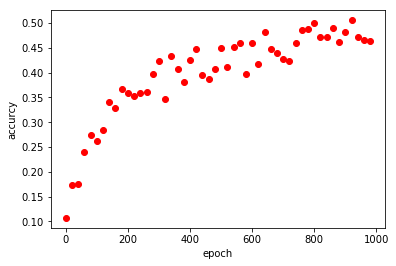

In [53]:
with tf.Session() as sess:
    sess.run(init)
    
    #train
    for i in range(num_epochs):
        batch_x, batch_y = get_batches(x=x_train, y=y_train, batch_size=batch_size, replacement=False)
        sess.run(train, feed_dict={
            x: batch_x,
            y_true: batch_y,
            drop_rate: dropout_prob_train
        })
        
        #progress output
        if i % epochs_between_output == 0:
            print("step: {}".format(i))
            matches = tf.equal(tf.argmax(y_true, 1), tf.argmax(logits, 1))
            acc_op = tf.reduce_mean(tf.cast(matches, dtype=tf.float32))
            acc_val = sess.run(acc_op, feed_dict={
                x: x_test,
                y_true: y_test,
                drop_rate: dropout_prob_test
            })
            accuracies.append(acc_val)
            print("acc: {}".format(acc_val))
            plt.plot([i], accuracies[-1], "o", color="red")
            plt.xlabel("epoch")
            plt.ylabel("accurcy")